In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import itertools
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                              
from tqdm import tqdm
import pandas as pd

In [42]:
class_names = ['Boat', 'Bus', 'Cycle','Helicopter','Truck']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [43]:
model = tf.keras.models.load_model('Vehicle_Long_Model.h5py')

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 32)       0

In [45]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['Test']
    output = []
    
    # Iterate through training and test sets

        
    images = []
    labels = []
        
    print("Loading {}".format(datasets[0]))
        
        # Iterate through each folder corresponding to a category
    for folder in os.listdir(datasets[0]):
          label = class_names_label[folder]
            
            # Iterate through each image in our folder
          for file in tqdm(os.listdir(os.path.join(datasets[0], folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(datasets[0], folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')   
        
    output.append((images, labels))

    return images,labels

In [46]:
test_images, test_labels = load_data()

Loading Test


100%|██████████| 6/6 [00:00<00:00, 1504.05it/s]


In [47]:
n_test = test_labels.shape[0]

print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of testing examples: 27
Each image is of size: (150, 150)


Scale The Data :

In [48]:
test_images = test_images / 255.0

In [54]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

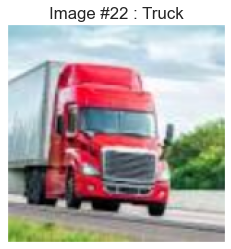

In [55]:
display_random_image(class_names, test_images, test_labels)

In [61]:
from keras import models
layer_outputs = [layer.output for layer in model.layers]

activation_models=models.Model(inputs=model.input,outputs=layer_outputs)
activations = activation_models.predict(test_images,verbose=0)

pred_labels=np.argmax(activations[12],axis=1) 

In [62]:
pred_labels

array([0, 0, 0, 3, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 1,
       4, 4, 1, 4, 4], dtype=int64)

In [63]:
def display_examples(class_names, images, labels,imgsize):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(imgsize):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [64]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels,len(mislabeled_images))

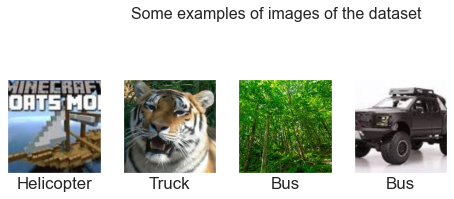

In [65]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

In [16]:
test_layers=[]
for i in range(len(activations)):
  test_layers.append(activations[i])


In [17]:
for i in range (len(test_layers)):
  print(i,".",test_layers[i].shape)

0 . (25, 148, 148, 32)
1 . (25, 74, 74, 32)
2 . (25, 72, 72, 32)
3 . (25, 36, 36, 32)
4 . (25, 34, 34, 32)
5 . (25, 17, 17, 32)
6 . (25, 15, 15, 32)
7 . (25, 7, 7, 32)
8 . (25, 5, 5, 32)
9 . (25, 2, 2, 32)
10 . (25, 128)
11 . (25, 128)
12 . (25, 5)


In [18]:
from sklearn import decomposition
pca=decomposition.PCA(n_components=2)
X=[0,0,0,0,0,0,0,0,0,0,0,0,0]
n_test0,x,y,z=test_layers[0].shape

X[0]=test_layers[0].reshape(n_test,x*y*z)

n_test1,x,y,z=test_layers[1].shape
numFeatures=x*y*z
X[1]=test_layers[1].reshape(n_test1,numFeatures)
n_test2,x,y,z=test_layers[2].shape
numFeatures=x*y*z
X[2]=test_layers[2].reshape(n_test2,numFeatures)
n_test3,x,y,z=test_layers[3].shape
numFeatures=x*y*z
X[3]=test_layers[3].reshape(n_test3,numFeatures)

#Layer 4
n_test4,x,y,z=test_layers[4].shape
numFeatures=x*y*z
X[4]=test_layers[4].reshape(n_test4,numFeatures)

n_test5,x,y,z=test_layers[5].shape
numFeatures=x*y*z
X[5]=test_layers[5].reshape(n_test5,numFeatures)

n_test6,x,y,z=test_layers[6].shape
numFeatures=x*y*z
X[6]=test_layers[6].reshape(n_test6,numFeatures)

n_test7,x,y,z=test_layers[7].shape
numFeatures=x*y*z
X[7]=test_layers[7].reshape(n_test7,numFeatures)

n_test8,x,y,z=test_layers[8].shape
numFeatures=x*y*z
X[8]=test_layers[8].reshape(n_test8,numFeatures)

n_test9,x,y,z=test_layers[9].shape
numFeatures=x*y*z
X[9]=test_layers[9].reshape(n_test9,numFeatures)

n_test10,y=test_layers[10].shape
X[10]=test_layers[10].reshape(n_test10,y)

n_test11,y=test_layers[11].shape
X[11]=test_layers[11].reshape(n_test11,y)

n_test12,y=test_layers[12].shape
X[12]=test_layers[12].reshape(n_test12,y)

In [19]:

df0=pca.fit_transform(X[0])
df1=pca.fit_transform(X[1])
df2=pca.fit_transform(X[2])
df3=pca.fit_transform(X[3])
df4=pca.fit_transform(X[4])
df5=pca.fit_transform(X[5])
df6=pca.fit_transform(X[6])
df7=pca.fit_transform(X[7])
df8=pca.fit_transform(X[8])
df9=pca.fit_transform(X[9])
df10=pca.fit_transform(X[10])
df11=pca.fit_transform(X[11])
df12=pca.fit_transform(X[12])

cor0=df0
cor1=df1
cor2=df2
cor3=df3
cor4=df4
cor5=df5
cor6=df6
cor7=df7
cor8=df8
cor9=df9
cor10=df10
cor11=df11
cor12=df12

In [20]:
from sklearn.cluster import KMeans
#LAYER 0

nb_clusters=4
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df0=kmeans.fit_predict(df0)

#LAYER 1


nb_clusters=6
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df1=kmeans.fit_predict(df1)

#LAYER 2

nb_clusters=7
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df2=kmeans.fit_predict(df2)

#LAYER 3

nb_clusters=3
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df3=kmeans.fit_predict(df3)

#LAYER 4

nb_clusters=2
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df4=kmeans.fit_predict(df4)

#LAYER 5

nb_clusters=8
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df5=kmeans.fit_predict(df5)

#LAYER 6

nb_clusters=4
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df6=kmeans.fit_predict(df6)

#LAYER 7

nb_clusters=8
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df7=kmeans.fit_predict(df7)

#LAYER 8

nb_clusters=5
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df8=kmeans.fit_predict(df8)

#LAYER 9

nb_clusters=9
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df9=kmeans.fit_predict(df9)

#LAYER 10

nb_clusters=4
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df10=kmeans.fit_predict(df10)

#LAYER 11

nb_clusters=8
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df11=kmeans.fit_predict(df11)

#LAYER 12

nb_clusters=12
kmeans = KMeans(n_clusters=nb_clusters, init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0)
df12=kmeans.fit_predict(df12)




In [21]:
#Groupe pour coloration et nommage des classes
classes=[]
names=[]
for elt in test_labels:
  if(elt==0):
    classes.append(0)
    names.append('Boat')
  elif(elt==1):
    classes.append(0.5)
    names.append('Bus')
  elif(elt==2):
    classes.append(0.7)
    names.append('Cycle')
  elif(elt==3):
    classes.append(0.9)
    names.append('Helicopter')
  elif(elt==4):
    classes.append(1)
    names.append('Truck')


In [22]:
input=pd.DataFrame(names,columns=['Class'])


df0=pd.DataFrame(df0,columns=['L1 C1'])
df1=pd.DataFrame(df1,columns=['L2 C1'])
df2=pd.DataFrame(df2,columns=['L3 C1'])
df3=pd.DataFrame(df3,columns=['L4 C1'])
df4=pd.DataFrame(df4,columns=['L5 C1'])
df5=pd.DataFrame(df5,columns=['L6 C1'])
df6=pd.DataFrame(df6,columns=['L7 C1'])
df7=pd.DataFrame(df7,columns=['L8 C1'])
df8=pd.DataFrame(df8,columns=['L9 C1'])
df9=pd.DataFrame(df9,columns=['L10 C1'])
df10=pd.DataFrame(df10,columns=['L11 C1'])
df11=pd.DataFrame(df11,columns=['L12 C1'])
df12=pd.DataFrame(df12,columns=['L13 C1'])



In [23]:
pred_names=[]
for elt in pred_labels:
    if(elt==0):
        pred_names.append('Boat')
    elif(elt==1):
        pred_names.append('Bus')
    elif(elt==2):
        pred_names.append('Cycle')
    elif(elt==3):
        pred_names.append('Helicopter')
    elif(elt==4):
        pred_names.append('Truck')
pred_names=pd.DataFrame(pred_names,columns=['class'])

In [24]:
df6.head()

,L7 C1
0,1
1,0
2,0
3,1
4,1


In [25]:
dfTot=pd.concat([input,df0,df1,df2,df3,df4,df5,df6
                 ,df7,df8,df9,df10,df11,df12,pred_names],axis=1,join='inner')

In [26]:
dfTot.head(10)

,Class,L1 C1,L2 C1,L3 C1,L4 C1,L5 C1,L6 C1,L7 C1,L8 C1,L9 C1,L10 C1,L11 C1,L12 C1,L13 C1,class
0,Boat,3,2,4,1,1,7,1,0,0,8,2,4,7,Boat
1,Boat,3,1,3,1,1,0,0,3,3,4,2,5,1,Boat
2,Boat,2,0,5,0,0,6,0,3,3,4,2,2,7,Boat
3,Boat,3,2,4,1,1,7,1,3,0,1,2,2,5,Helicopter
4,Boat,2,0,5,0,0,4,1,3,0,1,2,2,1,Boat
5,Bus,1,1,1,2,1,0,0,1,1,3,1,6,11,Bus
6,Bus,1,3,6,2,1,2,2,1,1,3,1,1,11,Bus
7,Bus,1,3,6,2,1,2,2,1,1,3,1,1,11,Bus
8,Bus,3,2,3,1,1,3,1,4,1,7,1,6,11,Bus
9,Bus,1,3,6,2,1,2,2,6,4,2,3,7,0,Bus


In [28]:
import plotly.express as px

color = pd.DataFrame(classes,columns=['Class']);
colorscale =[[0, 'black'],[0.5, 'Green'],[0.7,'rgb(98,118,83)'],[0.9,'rgb(190,186,218)'],[1,'blue']];

fig=px.parallel_categories(dfTot,dimensions=['Class','L1 C1','L2 C1','L3 C1', 
                                             'L4 C1','L5 C1','L6 C1','L7 C1','L8 C1',
                                             'L9 C1','L10 C1','L11 C1','L12 C1'
,'L13 C1','class'],
 labels={'Class':'Class Input','L1 C1':'Hidden Layer 1','L2 C1':'Hidden Layer 2',
         'L3 C1':'Hidden Layer 3','L4 C1':'Hidden Layer 4',
         'L5 C1':'Hidden Layer 5','L6 C1':'Hidden Layer 6',
         'L7 C1':'Hidden Layer 7','L8 C1':'Hidden Layer 8',
         'L9 C1':'Hidden Layer 9','L10 C1':'Hidden Layer 10',
         'L11 C1':'Hidden Layer 11','L12 C1':'Hidden Layer 12',
         'L13 C1':'Hidden Layer 13',
         'class':'Output Classes'},color=classes,color_continuous_scale=colorscale)
fig.update(layout_coloraxis_showscale=False)
fig

In [29]:
# !pip install chart_studio
# import chart_studio.tools as tls

# import chart_studio
# username = 'Username' # your username
# api_key = 'API Key' # your api key - go to profile > settings > regenerate key
# chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
# import chart_studio.plotly as py
# import chart_studio.tools as tls

# py.plot(fig,filename='Vehicle_Long',auto_open=False)
fig.write_html("Vehicle_Long.html")

'https://plotly.com/~kaansen/42/'

In [30]:
#CLASSE 0
color = pd.DataFrame(classes,columns=['Class']);
colorscale =[[0, 'red'],[0.5, 'gray'],[0.7,'gray'],[0.9,'gray'],[1,'gray']];

fig=px.parallel_categories(dfTot,dimensions=['Class','L1 C1','L2 C1','L3 C1', 
                                             'L4 C1','L5 C1','L6 C1','L7 C1','L8 C1',
                                             'L9 C1','L10 C1','L11 C1','L12 C1'
,'L13 C1','class'],
 labels={'Class':'Class Input','L1 C1':'Hidden Layer 1','L2 C1':'Hidden Layer 2',
         'L3 C1':'Hidden Layer 3','L4 C1':'Hidden Layer 4',
         'L5 C1':'Hidden Layer 5','L6 C1':'Hidden Layer 6',
         'L7 C1':'Hidden Layer 7','L8 C1':'Hidden Layer 8',
         'L9 C1':'Hidden Layer 9','L10 C1':'Hidden Layer 10',
         'L11 C1':'Hidden Layer 11','L12 C1':'Hidden Layer 12',
         'L13 C1':'Hidden Layer 13',
         'class':'Output Classes'},color=classes,color_continuous_scale=colorscale)
fig.update(layout_coloraxis_showscale=False)
fig

In [31]:
# py.plot(fig,filename='Vehicle_Long_Boat',auto_open=False)
fig.write_html("Vehicle_Long_Boat.html")

'https://plotly.com/~kaansen/44/'

In [33]:
#CLASSE 1
color = pd.DataFrame(classes,columns=['Class']);
colorscale =[[0, 'gray'],[0.5, 'red'],[0.7,'gray'],[0.9,'gray'],[1,'gray']];

fig=px.parallel_categories(dfTot,dimensions=['Class','L1 C1','L2 C1','L3 C1', 
                                             'L4 C1','L5 C1','L6 C1','L7 C1','L8 C1',
                                             'L9 C1','L10 C1','L11 C1','L12 C1'
,'L13 C1','class'],
 labels={'Class':'Class Input','L1 C1':'Hidden Layer 1','L2 C1':'Hidden Layer 2',
         'L3 C1':'Hidden Layer 3','L4 C1':'Hidden Layer 4',
         'L5 C1':'Hidden Layer 5','L6 C1':'Hidden Layer 6',
         'L7 C1':'Hidden Layer 7','L8 C1':'Hidden Layer 8',
         'L9 C1':'Hidden Layer 9','L10 C1':'Hidden Layer 10',
         'L11 C1':'Hidden Layer 11','L12 C1':'Hidden Layer 12',
         'L13 C1':'Hidden Layer 13',
         'class':'Output Classes'},color=classes,color_continuous_scale=colorscale)
fig.update(layout_coloraxis_showscale=False)
fig

In [34]:
# py.plot(fig,filename='Vehicle_Long_Bus',auto_open=False)
fig.write_html("Vehicle_Long_Bus.html")

'https://plotly.com/~kaansen/46/'

In [35]:
#CLASSE 2
color = pd.DataFrame(classes,columns=['Class']);
colorscale =[[0, 'gray'],[0.5, 'gray'],[0.7,'red'],[0.9,'gray'],[1,'gray']];

fig=px.parallel_categories(dfTot,dimensions=['Class','L1 C1','L2 C1','L3 C1', 
                                             'L4 C1','L5 C1','L6 C1','L7 C1','L8 C1',
                                             'L9 C1','L10 C1','L11 C1','L12 C1'
,'L13 C1','class'],
 labels={'Class':'Class Input','L1 C1':'Hidden Layer 1','L2 C1':'Hidden Layer 2',
         'L3 C1':'Hidden Layer 3','L4 C1':'Hidden Layer 4',
         'L5 C1':'Hidden Layer 5','L6 C1':'Hidden Layer 6',
         'L7 C1':'Hidden Layer 7','L8 C1':'Hidden Layer 8',
         'L9 C1':'Hidden Layer 9','L10 C1':'Hidden Layer 10',
         'L11 C1':'Hidden Layer 11','L12 C1':'Hidden Layer 12',
         'L13 C1':'Hidden Layer 13',
         'class':'Output Classes'},color=classes,color_continuous_scale=colorscale)
fig.update(layout_coloraxis_showscale=False)
fig

In [36]:
# py.plot(fig,filename='Vehicle_Long_Cycle',auto_open=False)
fig.write_html("Vehicle_Long_Cycle.html")

'https://plotly.com/~kaansen/48/'

In [37]:
#CLASSE 3
color = pd.DataFrame(classes,columns=['Class']);
colorscale =[[0, 'gray'],[0.5, 'gray'],[0.7,'gray'],[0.9,'red'],[1,'gray']];

fig=px.parallel_categories(dfTot,dimensions=['Class','L1 C1','L2 C1','L3 C1', 
                                             'L4 C1','L5 C1','L6 C1','L7 C1','L8 C1',
                                             'L9 C1','L10 C1','L11 C1','L12 C1'
,'L13 C1','class'],
 labels={'Class':'Class Input','L1 C1':'Hidden Layer 1','L2 C1':'Hidden Layer 2',
         'L3 C1':'Hidden Layer 3','L4 C1':'Hidden Layer 4',
         'L5 C1':'Hidden Layer 5','L6 C1':'Hidden Layer 6',
         'L7 C1':'Hidden Layer 7','L8 C1':'Hidden Layer 8',
         'L9 C1':'Hidden Layer 9','L10 C1':'Hidden Layer 10',
         'L11 C1':'Hidden Layer 11','L12 C1':'Hidden Layer 12',
         'L13 C1':'Hidden Layer 13',
         'class':'Output Classes'},color=classes,color_continuous_scale=colorscale)
fig.update(layout_coloraxis_showscale=False)
fig

In [38]:
# py.plot(fig,filename='Vehicle_Long_Helicopter',auto_open=False)
fig.write_html("Vehicle_Long_Helicopter.html")

'https://plotly.com/~kaansen/50/'

In [39]:
#CLASSE 4
color = pd.DataFrame(classes,columns=['Class']);
colorscale =[[0, 'gray'],[0.5, 'gray'],[0.7,'gray'],[0.9,'gray'],[1,'red']];

fig=px.parallel_categories(dfTot,dimensions=['Class','L1 C1','L2 C1','L3 C1', 
                                             'L4 C1','L5 C1','L6 C1','L7 C1','L8 C1',
                                             'L9 C1','L10 C1','L11 C1','L12 C1'
,'L13 C1','class'],
 labels={'Class':'Class Input','L1 C1':'Hidden Layer 1','L2 C1':'Hidden Layer 2',
         'L3 C1':'Hidden Layer 3','L4 C1':'Hidden Layer 4',
         'L5 C1':'Hidden Layer 5','L6 C1':'Hidden Layer 6',
         'L7 C1':'Hidden Layer 7','L8 C1':'Hidden Layer 8',
         'L9 C1':'Hidden Layer 9','L10 C1':'Hidden Layer 10',
         'L11 C1':'Hidden Layer 11','L12 C1':'Hidden Layer 12',
         'L13 C1':'Hidden Layer 13',
         'class':'Output Classes'},color=classes,color_continuous_scale=colorscale)
fig.update(layout_coloraxis_showscale=False)
fig

In [40]:
# py.plot(fig,filename='Vehicle_Long_Truck',auto_open=False)
fig.write_html("Vehicle_Long_Truck.html")

'https://plotly.com/~kaansen/52/'